In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import _pickle as pickle
from PIL import Image
import os

import requests
import cv2

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

In [6]:
from bechdelai.utils.video import extract_frames_from_videos
from bechdelai.vision.video import Video

# Paths

In [45]:
os.listdir("c:/git/videos/eng")

['American Pie Official Trailer #1 - (1999) HD.mp4',
 'Dune Final Trailer (2021) _ Movieclips Trailers.mp4',
 'GOOD MOURNING Trailer (2022) Megan Fox.mp4',
 'LITTLE WOMEN - Official Trailer (HD).mp4',
 'Mulan Trailer.mp4',
 'THE BATMAN – Main Trailer.mp4']

In [48]:
# path = 'Shang.Chi.and.the.Legend.of.the.Ten.Rings.2021.MULTi.TRUEFRENCH .1080p.BluRay.AC3.x264.WwW.ZoNe-TelecharGement.CaM.mkv'
# path = r"C:\Users\theo.alvesdacosta\Downloads\RAID DINGUE Bande Annonce (Dany Boon, Comédie 2017).mp4"
path = 'c:/git/videos/english/The Batman Trailer - The Bat and The Cat (2022) _ Movieclips Trailers-SeA_Fno-3QQ.mp4'
# path = 'c:/git/videos/eng/American Pie Official Trailer #1 - (1999) HD.mp4'
path = "c:/git/videos/eng/Mulan Trailer.mp4"

# Load & prepare images

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

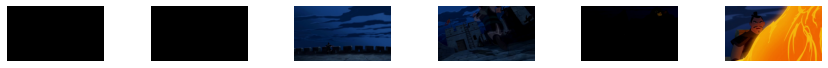

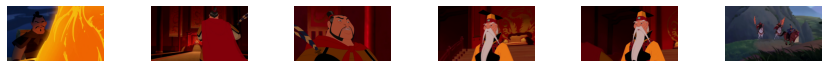

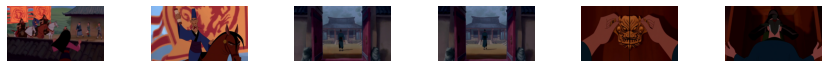

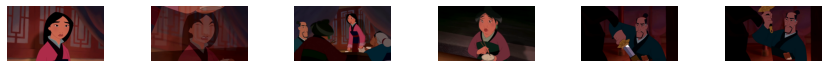

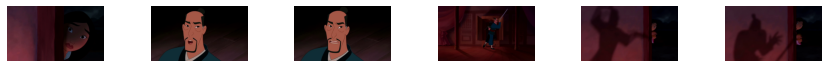

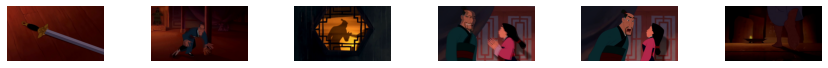

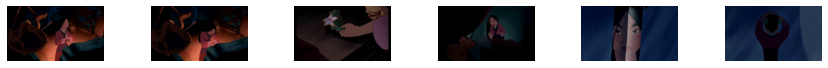

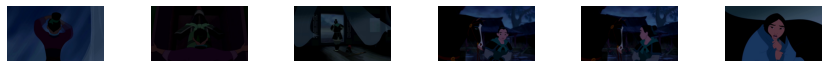

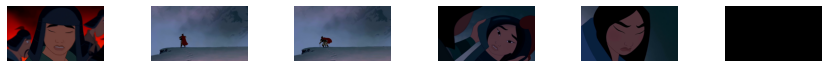

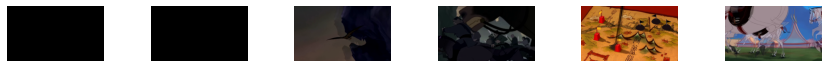

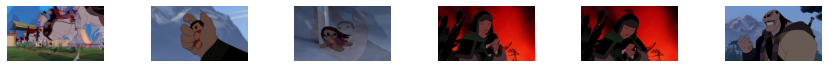

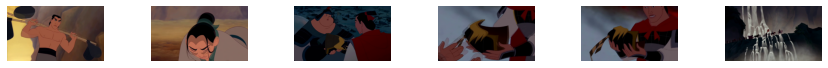

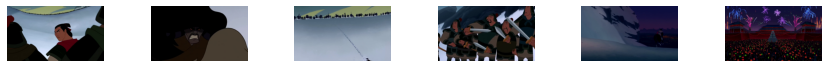

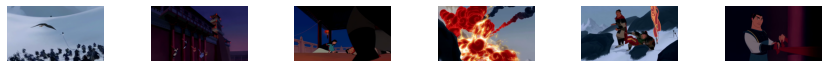

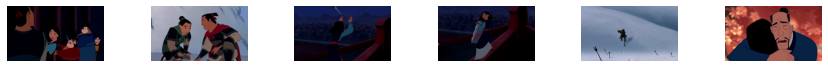

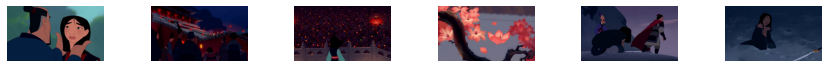

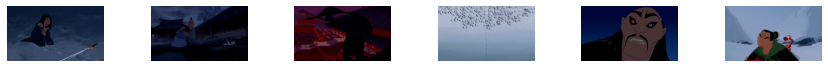

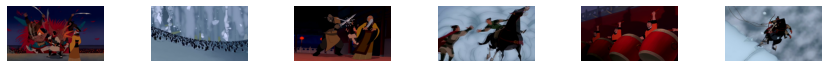

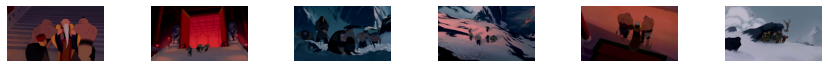

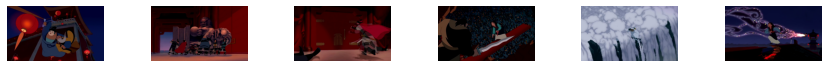

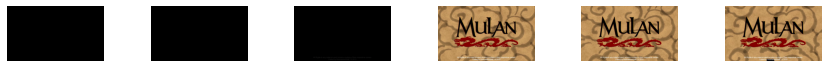

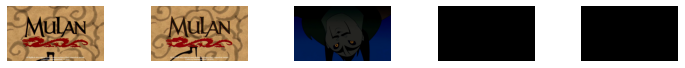

In [49]:
video = Video(path = path,frame_rate = 1,max_seconds = None)
video.resize(width = 600)
video.show_frames()

In [ ]:
video.replay()

# Apply CLIP algorithm

In [34]:
from bechdelai.vision.clip import CLIP

In [35]:
from bechdelai.utils.timeline import convert_to_timeline,fn_timeline

import plotly.express as px

In [36]:
clip = CLIP()

Loading CLIP model


In [50]:
prompts_dict =  {
    "Base":[
        "background",
        "a black or colored screen with texts",
        "blank",
        "unknown",
        "a blurry picture",
    ],
    "Landscape":[
        'an urban area',
        'a building',
        'a nature landscape',
        'a city street',
        'a school',
        'inside a house',
    ],
    "Romantic":[
        'a woman is undressed, naked, or shown in a sexy way',
        'people kissing',
        'couple making love',
    ],
    "Action":[
    ],
    "Dialogue":[
        'a young woman',
        'a young man',
        'an old woman',
        'an old man',
        'two women speaking together',
        'two men speaking together',
        'a man and a woman speaking together',
        'a group of persons',
    ]
}

clip.set_prompts(prompts_dict)

In [51]:
%%time
preds,probas = clip.predict(video)

Wall time: 8.64 s


In [52]:
# preds_reduced = clip.reduce_preds_by_category(preds)

In [53]:
clip.show_preds_area(probas)

In [54]:
clip.replay(video,probas)

interactive(children=(Play(value=0, description='Press play', interval=500, max=130), Output()), _dom_classes=…

IntSlider(value=0, max=130)

In [56]:
x = (preds.melt(ignore_index = False)
    .reset_index(drop = False)
    .rename(columns = {"index":"frame_id","variable":"prompt"})
)

x["rank"] = x.groupby(["frame_id"])["value"].transform("rank",ascending = False)

x = x.query("rank<=1")

x = x.merge(clip.prompts,on = "prompt").sort_values("frame_id")

x["sequence_id"] = x.groupby("prompt")["frame_id"].transform(fn_timeline)

timeline = convert_to_timeline(x,"prompt",show = False,xaxis_time=True)
timeline = timeline.merge(clip.prompts,on = "prompt")

In [57]:
timeline

,prompt,sequence_id,min,max,start,end,duration,category
0,a black or colored screen with texts,0,0,2,2022-01-01 00:00:00,2022-01-01 00:00:02,0 days 00:00:02,Base
1,a black or colored screen with texts,1,53,56,2022-01-01 00:00:53,2022-01-01 00:00:56,0 days 00:00:03,Base
2,a black or colored screen with texts,2,99,100,2022-01-01 00:01:39,2022-01-01 00:01:40,0 days 00:00:01,Base
3,a black or colored screen with texts,3,120,123,2022-01-01 00:02:00,2022-01-01 00:02:03,0 days 00:00:03,Base
4,a black or colored screen with texts,4,129,131,2022-01-01 00:02:09,2022-01-01 00:02:11,0 days 00:00:02,Base
...,...,...,...,...,...,...,...,...
87,two men speaking together,10,104,106,2022-01-01 00:01:44,2022-01-01 00:01:46,0 days 00:00:02,Dialogue
88,two men speaking together,11,108,109,2022-01-01 00:01:48,2022-01-01 00:01:49,0 days 00:00:01,Dialogue
89,two men speaking together,12,112,113,2022-01-01 00:01:52,2022-01-01 00:01:53,0 days 00:00:01,Dialogue
90,two men speaking together,13,114,115,2022-01-01 00:01:54,2022-01-01 00:01:55,0 days 00:00:01,Dialogue


In [58]:
fig = px.timeline(timeline,
  x_start = "start",
  x_end = "end",
  color = "prompt",
  y = "category",
#     facet_row = "category",
  color_discrete_sequence = px.colors.qualitative.Alphabet
)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-0.5,
    xanchor="right",
    x=1
))
# fig.update_layout(showlegend=False)
fig

In [26]:
preds_cat = (preds
 .melt(ignore_index = False)
 .reset_index()
 .rename(columns = {"index":"frame_id","variable":"prompt"})
 .merge(clip.prompts,on = "prompt")
 .groupby(["frame_id","category"]).agg({"value":"max"})["value"]
 .unstack("category")
)

preds_cat = softmax(preds_cat,axis = 1)

NameError: name 'softmax' is not defined

In [ ]:
preds_for_timeline = preds_cat.melt(ignore_index = False).reset_index().query("value > 0.5")
preds_for_timeline

In [ ]:
timeline = convert_to_timeline(
    preds_for_timeline,
    "category",
    show = True,
    xaxis_time = True,
)
timeline

In [ ]:
clip.show_preds_area(preds_cat)

In [ ]:
clip.replay(video,preds_cat)